<a href="https://colab.research.google.com/github/ag826/AIPI590_XAI_F25/blob/main/Assignment_machine_learning_court.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment - Interpretable ML
**Adil Keku Gazder**

**ag825@duke.edu**

**For AIPI 590 - XAI, Fall 2025**

**Duke University**

# 👩‍⚖️ ⚖️ Machine Learning Court

Assigned case: **⚖️ Case 3: Recidivism Prediction 🟦 Defense**





## ⚖️ Case 3: Recidivism Risk – COMPAS Dataset
#### 🔍 Scenario
Malik Johnson, a 27-year-old with one prior felony, was flagged as low risk by an AI risk assessment tool and granted parole. Some community stakeholders have questioned whether this was an appropriate classification.

#### 🟥 Prosecution
Examine whether the model may have underestimated risk factors. Use explanation techniques to uncover potential oversights or inconsistencies.

#### 🟦 Defense
Argue that the decision was reasonable based on the model's criteria. Use explanation tools to show which features were most influential and whether the classification aligns with data-driven patterns.

Adapted from the starter code shared by Brinnae Bent, shared here: https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/assignments/machine_learning_court.ipynb

In [1]:
# ⚖️ Case 3: Recidivism Prediction (COMPAS Dataset)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load dataset
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df_compas = pd.read_csv(url)

# Filter relevant columns and preprocess
features = ['age', 'sex', 'race', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree']
df = df_compas[features + ['two_year_recid']].dropna()
df = df[df['c_charge_degree'].isin(['F', 'M'])]  # Filter valid degrees

# Encode categoricals
df = df.copy()
df['sex'] = df['sex'].astype('category').cat.codes
df['race'] = df['race'].astype('category').cat.codes
df['c_charge_degree'] = df['c_charge_degree'].astype('category').cat.codes

X = df[features]
y = df['two_year_recid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_compas = RandomForestClassifier(random_state=42)
model_compas.fit(X_train, y_train)
print(classification_report(y_test, model_compas.predict(X_test)))


              precision    recall  f1-score   support

           0       0.68      0.68      0.68       823
           1       0.57      0.57      0.57       620

    accuracy                           0.63      1443
   macro avg       0.62      0.62      0.62      1443
weighted avg       0.63      0.63      0.63      1443



> This dataset explores various factors which try and model a two year recidivism flag for individuals. We specifically only include the following features: age, sex, race, number of priors, juvinile felony count, juvinile misdimenour count, juvinile other instances count and the degree of the current charge.

> Our model does not currently include a bunch of features available in the original dataset, these features could be categorised into the following buckets. A justification for why these categories of features were not included have been added below:
> - Identifiers and personal information: These serve no purpose in the predictive model and may include an unnecessary bias factor.
> - Dates and times: These are temporal factors which may contribute to overfit and add noise
> - Case specific information: Simply categorical descriptions, with very high cardinality and no direct predictive value.
> - Post prediction knowledge variables: These can not be included in the predictor set as it gives the model unfair future knowledge which will be reflected in the test data loss.

*Partial justifications and categorizations above have been added with a bit of help from Perplexity at 1:30pm on Saturday 09/20*

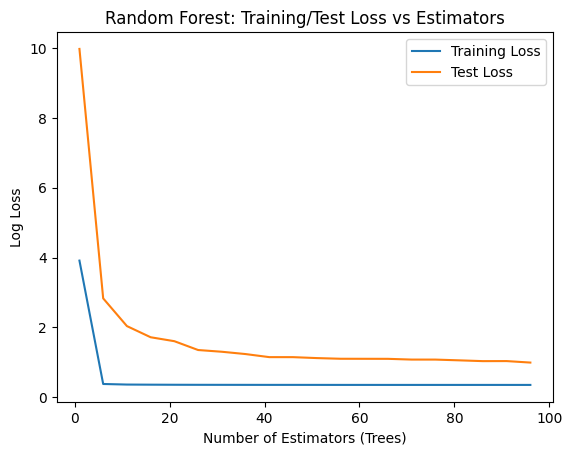

In [6]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

train_losses, test_losses = [], []
estimator_range = range(1, 101, 5)  # Evaluate from 1 to 100 trees (step of 5)

for n in estimator_range:
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    test_loss = log_loss(y_test, model.predict_proba(X_test))
    train_losses.append(train_loss)
    test_losses.append(test_loss)

plt.plot(estimator_range, train_losses, label="Training Loss")
plt.plot(estimator_range, test_losses, label="Test Loss")
plt.xlabel("Number of Estimators (Trees)")
plt.ylabel("Log Loss")
plt.title("Random Forest: Training/Test Loss vs Estimators")
plt.legend()
plt.show()


> Plotting training and test loss vs number of estimators above, we see that with the selected model (RF, random 42), the model by default will work with 100 trees. This choice makes sense and is justified with the graph above for the following reasons:
> - Loss stabilization: test loss seems to dramatically decrease (as expected) and then converge and tends to stabilize near 100 trees, showing no additional benefit with more trees.
> - No overfitting: We observe that the model fits the data well as training loss tends to stay low. Test loss does not increase as more trees are added.
> - No reason to consider more than 100 trees: Unnecessary increase in computational costs with no/neglegible improvement in the model performance (diminishing returns)

*Partial justifications and categorizations above have been added with a bit of help from Perplexity at 1:30pm on Saturday 09/20*

In [2]:
# 🎯 Focus Instance: Recidivism Risk Case (Malik Johnson)
focus_instance_compas = pd.DataFrame([{
    "age": 27,
    "sex": 1,  # Male
    "race": 1,  # African-American
    "priors_count": 1,
    "juv_fel_count": 0,
    "juv_misd_count": 0,
    "juv_other_count": 0,
    "c_charge_degree": 1  # Felony
}])

pred = model_compas.predict(focus_instance_compas)
print("Prediction for Malik Johnson (Recidivism):", pred)


Prediction for Malik Johnson (Recidivism): [0]
